In [1]:
import nibabel as nb
import os
import numpy as np
import scipy.io as sio
import scipy.optimize
from Tkinter import Tk
from tkFileDialog import askdirectory
#import libtiff 
import matplotlib.pyplot as plt
from Tkinter import Tk
from tkFileDialog import askopenfilename
#import cv2
%matplotlib inline

# Get video time (output from matlab)

In [2]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
Tvid=Ua['Time']
Tvid.shape

/media/sophie/e14406b6-b6d1-4305-86e1-f0fe5128f521/100245/conjtrol_2017-02-14-145908-0000Time.mat


(1, 13796)

# Get head video data

Open the head saved as 32bit nii

In [3]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

/media/sophie/e14406b6-b6d1-4305-86e1-f0fe5128f521/100245/conjtrol_2017-02-14-145908-0000head.nii


(17, 9, 13796, 1)

In [4]:
# Find end of onset of light and begining of offset (to align to behavior) 

In [5]:
M=np.mean(np.mean(data,0),0)
M=M-np.min(M)
Mav=M.mean()
M=M/Mav

In [6]:
M.shape

(13796, 1)

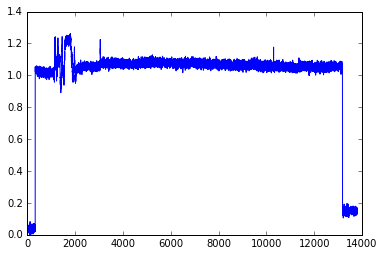

In [7]:
plt.plot(M)

In [8]:
liston=[i for i in range(len(M)) if M[i]>0.8]
#liston[0]
max(liston)

13182

In [9]:
def model(x,a,b,c,d):
    if x<a:
        return b
    elif x<c:
        return b+(x-a)*d
    else:
        return (c-a)*d+b

In [10]:
Ms=M[range(liston[0]-8,liston[0]+8)]-M[liston[0]-8]

In [11]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))])   

In [12]:
liston[0]-8

328

In [13]:
res = scipy.optimize.minimize(Sq,x0=[6.5,0.00,7.5,1.2])

In [14]:
ON=liston[0]-8+res.x[2]
print(ON)

335.5


In [15]:
ONint=np.int(np.ceil(ON))
print(ONint)

336


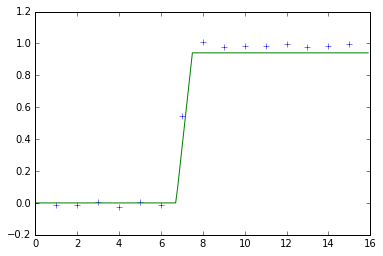

In [16]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

Model offset and find precise offset time

In [17]:
len(M)

13796

In [18]:
Ms=M[range(max(liston)-6,max(liston)+6)]

In [19]:
def Sq(X):
    return sum([(model(i,X[0],X[1],X[2],X[3])-Ms[i])**2 for i in range(len(Ms))]) 

In [20]:
res = scipy.optimize.minimize(Sq,x0=[6.2,1,7.2,-1])

In [21]:
OFF=liston[len(liston)-1]-6+res.x[0]
#OFF=liston[len(liston)-1]
print(OFF)
OFFint=np.int(np.floor(OFF))
print(OFFint)

13182.2567694
13182


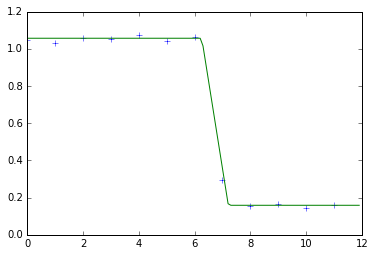

In [22]:
plt.plot(np.squeeze(Ms),'+')
plt.plot(np.arange(0,len(Ms),0.1),[model(i,res.x[0],res.x[1],res.x[2],res.x[3]) for i in np.arange(0,len(Ms),0.1)])
plt.show()

# Save times were light is on

In imageJ: choose subsack between these 2 values

In [23]:
print(ONint+1)
print(OFFint+1)
print(ON)
print(OFF)
print(OFFint-ONint)
print(OFF-ON)

337
13183
335.5
13182.2567694
12846
12846.7567694


In [24]:
Tvid=Tvid.T

In [27]:
TimeOn=[Tvid[i] for i in range(ONint,(OFFint+1))]

In [28]:
Tinit=(ON-(ONint-1))*(Tvid[ONint]-Tvid[ONint-1])+Tvid[ONint-1]

In [29]:
Toff=(OFF-OFFint)*(Tvid[OFFint+1]-Tvid[OFFint])+Tvid[OFFint]

In [30]:
Toff-Tinit  

array([ 128.41306769])

In [31]:
np.mean((Tvid[100:(len(Tvid))])-np.array(Tvid[99:(len(Tvid)-1)]))


0.010008789062500001

In [32]:
np.std((Tvid[100:(len(Tvid))])-np.array(Tvid[99:(len(Tvid)-1)]))


0.0017324391432026718

In [33]:
#Ttest=np.array(Tvid.T[2:(len(Tvid.T))])-np.array(Tvid.T[1:(len(Tvid.T)-1)])
#plt.plot(Ttest)
#plt.axis([0,100,19.5,150])

In [34]:
TimeOnFinal=(np.array(TimeOn)-Tinit)/1000

In [35]:
np.max(TimeOnFinal)

0.12841050000000001

In [36]:
Fileout="".join(filename[i] for i in range(len(filename)-4))

In [37]:
OutFilename=Fileout+'OnVid.mat'

In [38]:
OutFilename

'/media/sophie/e14406b6-b6d1-4305-86e1-f0fe5128f521/100245/conjtrol_2017-02-14-145908-0000TimeOnVid.mat'

In [39]:
sio.savemat(OutFilename, {'TimeFluoOnVid':TimeOnFinal,'ONint':ONint+1,'OFFint':OFFint+1})
